# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost


## Name: Yao Gahounzo

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0   # Depth of soil [cm]
dz = 15.0    # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0   # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25    # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25    # Time step [year]

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
# Load the data PermafrostTemperatureScenarios.csv

data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]    # year 
T_15 = data[:,1]      # data of linear increase in mean annual temperature at a rate 1.5 °C
T_30 = data[:,2]      # data of linear increase in mean annual temperature at a rate 3.0 °C
T_45 = data[:,3]      # data of linear increase in mean annual temperature at a rate 4.5 °C

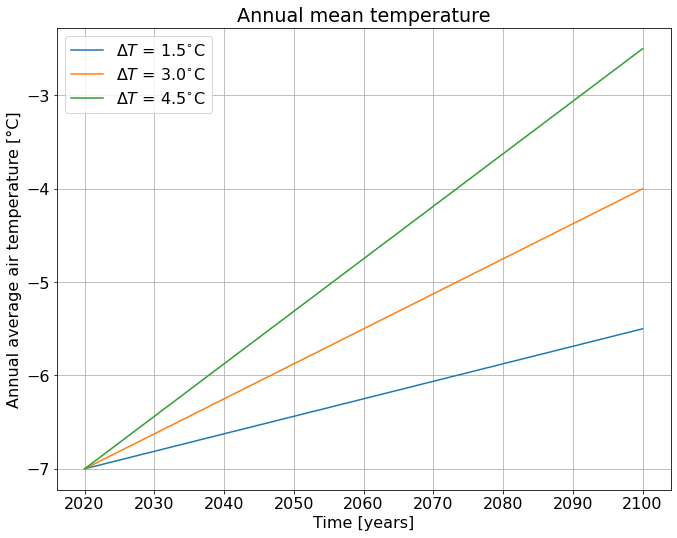

In [3]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

# Plot 
plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C') # plot mean annual temperature at a rate 1.5 °C
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C') # plot mean annual temperature at a rate 3.0 °C
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C') # plot mean annual temperature at a rate 4.5 °C
plt.legend(loc='upper left')                                # legend
plt.grid()                                                  # show the grid
plt.xlabel('Time [years]')                                  # x-axis label
plt.ylabel('Annual average air temperature [°C]')           # y-axis label
plt.title('Annual mean temperature')                       
plt.show()

#### 2.2 Setup the Simulation Time Period

In [4]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [5]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

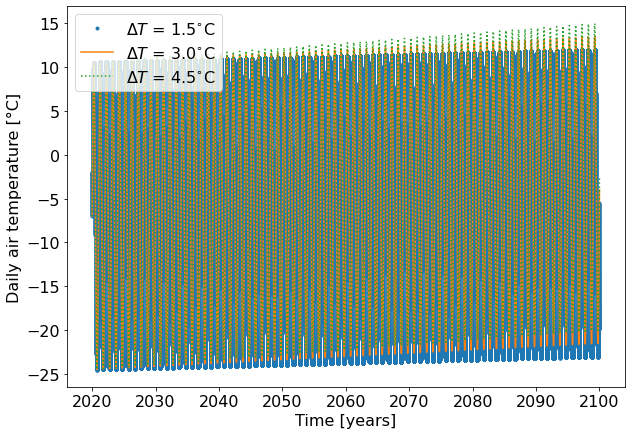

In [6]:
# boundary condition with the mean annual temperature at a rate 1.5 °C data
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t) 
# boundary condition with the mean annual temperature at a rate 3.0 °C data
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
# boundary condition with the mean annual temperature at a rate 4.5 °C data
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

# Plots of the boundary conditions
plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, '.', label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, ':', label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [7]:
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [8]:
Ts0 = Tbottom*np.ones((Nz,1))

### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

In [9]:
# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(2.0*dz**2) #Note division by 2.0
print('Diffusion number '+str(alpha))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.20540910647038682


In [10]:
# Matrix A
A = np.diag((1 + 2.0*alpha)*np.ones((Nz))) + \
    np.diag(-alpha*np.ones((Nz-1)),1) + \
    np.diag(-alpha*np.ones((Nz-1)),-1)
    
A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

# Matrix B
B = np.diag((1 - 2.0*alpha)*np.ones((Nz))) + \
    np.diag(alpha*np.ones((Nz-1)),1) + \
    np.diag(alpha*np.ones((Nz-1)),-1)
    
B[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
B[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

### 7. Preallocate Storage for Soil Temperatures

In [11]:
#Ts = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [12]:
AivB = np.matmul(np.linalg.pinv(A),B)

# subroutine that computes the solution a specific boundary conditions
def Tss(Ttop, AivB):
    
    Ts = np.zeros((Nz,Nt))
    for i in np.arange(Nt):
        if(i==0):
            Tsi = Ts0
        else:
            Tsi = Ts[:,i-1]
            Tsi[0] = Ttop[i]
            Tsi[-1] = Tbottom

        Tsip1 = np.matmul(AivB,Tsi)

        Ts[:,i] = np.squeeze(Tsip1)
    return Ts

# solution with boundary condition with the mean annual temperature at a rate 1.5 °C data
Ts15 = Tss(Ttop_15, AivB)   
# solution with boundary condition with the mean annual temperature at a rate 3.0 °C data
Ts30 = Tss(Ttop_30, AivB)
# solution with boundary condition with the mean annual temperature at a rate 4.5 °C data
Ts45 = Tss(Ttop_45, AivB)

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.

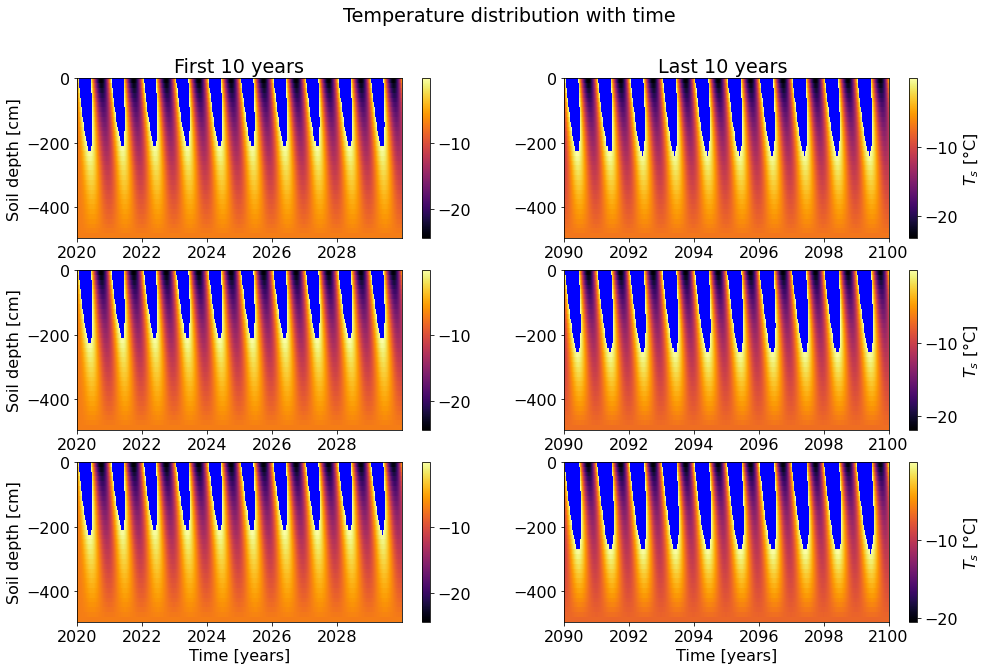

In [13]:
# Extract the firt 10 year index
if10 = (np.absolute(t-2030)).argmin()
# Extract the last 10 year index
il10 = (np.absolute(t-2090)).argmin()

# Mesh grid for the first 10 year and the spatial domain
t_f10,zz_f10 = np.meshgrid(t[:if10],z)
# Mesh grid for the last 10 year and the spatial domain
t_l10,zz_l10 = np.meshgrid(t[il10:],z)

#mask the tempratures
Ts15_frozen = np.ma.masked_where(Ts15 > 0.0,Ts15)
Ts30_frozen = np.ma.masked_where(Ts30 > 0.0,Ts30)
Ts45_frozen = np.ma.masked_where(Ts45 > 0.0,Ts45)


plt.figure(figsize=(16,10))
current_cmap = plt.cm.get_cmap('inferno').copy()
current_cmap.set_bad(color='blue')

# plot the solution for the first 10 years, with the mean annual temperature at a rate 1.5 °C data
plt.subplot(3,2,1)
plt.pcolormesh(t_f10,-zz_f10,Ts15_frozen[:,:if10],shading='auto',cmap=current_cmap) 
plt.colorbar()
plt.ylabel('Soil depth [cm]')
plt.title('First 10 years')

# plot the solution for the last 10 years, with the mean annual temperature at a rate 1.5 °C data
plt.subplot(3,2,2)
plt.pcolormesh(t_l10,-zz_l10,Ts15_frozen[:,il10:],shading='auto',cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')
plt.title('Last 10 years ')

# plot the solution for the first 10 years, with the mean annual temperature at a rate 3.0 °C data
plt.subplot(3,2,3)
plt.pcolormesh(t_f10,-zz_f10,Ts30_frozen[:,:if10],shading='auto',cmap=current_cmap) 
plt.colorbar()
plt.ylabel('Soil depth [cm]')

# plot the solution for the last 10 years, with the mean annual temperature at a rate 3.0 °C data
plt.subplot(3,2,4)
plt.pcolormesh(t_l10,-zz_l10,Ts30_frozen[:,il10:],shading='auto',cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')

# plot the solution for the first 10 years, with the mean annual temperature at a rate 4.5 °C data
plt.subplot(3,2,5)
plt.pcolormesh(t_f10,-zz_f10,Ts45_frozen[:,:if10],shading='auto',cmap=current_cmap) 
plt.colorbar()
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')

# plot the solution for the last 10 years, with the mean annual temperature at a rate 4.5 °C data
plt.subplot(3,2,6)
plt.pcolormesh(t_l10,-zz_l10,Ts45_frozen[:,il10:],shading='auto',cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')

plt.suptitle('Temperature distribution with time')
plt.show()

The three climate change scenarios have different impact on the temperature distribution. As $\Delta T$ increases the temperature distribution increases propotionally throughout the soil depth and we have to go a little deeper into soil to find the active layer thickness. The active layer thickness vary according to the scenario, but it starts just above 200 cm for each scenario. This is due to the high concentrations of carbon dioxide in the atmosphere, which causes more long-wave radiation to backscatter, the surface is kept at higher temperatures, impacting near and interior ground surface temperatures. Also the thickness of the active layer for each period of 10 years stays almost constant. We observe that the near-surface (top 10 cm) remains slightly thawed each year throughout the simulation period. 

2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 

In [14]:
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()


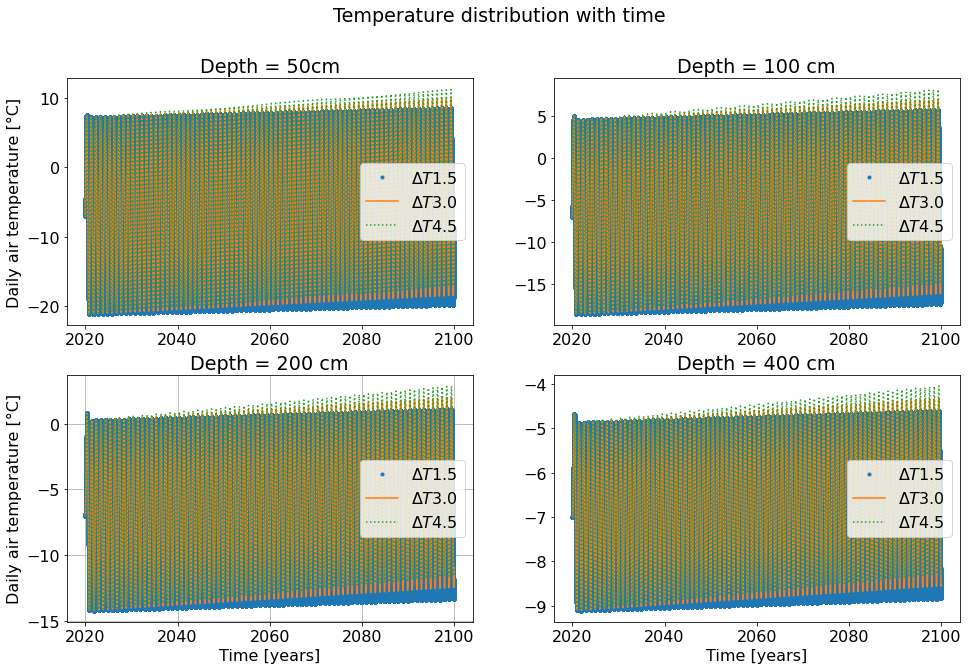

In [15]:
# plot of the temperature distribution with time at depth 50 cm
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(t,Ts15[iz50,:],'.',label='$\Delta T 1.5$')
plt.plot(t,Ts30[iz50,:],label='$\Delta T 3.0$')
plt.plot(t,Ts45[iz50,:],':',label='$\Delta T 4.5$')
plt.legend()
plt.ylabel('Daily air temperature [°C]')
plt.title('Depth = 50cm')

# plot of the temperature distribution with time at depth 100 cm
plt.subplot(2,2,2)
plt.plot(t,Ts15[iz100,:],'.',label='$\Delta T 1.5$')
plt.plot(t,Ts30[iz100,:],label='$\Delta T 3.0$')
plt.plot(t,Ts45[iz100,:],':',label='$\Delta T 4.5$')
plt.legend()
plt.title('Depth = 100 cm')

# plot of the temperature distribution with time at depth 200 cm
plt.subplot(2,2,3)
plt.plot(t,Ts15[iz200,:],'.',label='$\Delta T 1.5$')
plt.plot(t,Ts30[iz200,:],label='$\Delta T 3.0$')
plt.plot(t,Ts45[iz200,:],':',label='$\Delta T 4.5$')
plt.legend()
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.title('Depth = 200 cm')

# plot of the temperature distribution with time at depth 400 cm
plt.subplot(2,2,4)
plt.plot(t,Ts15[iz400,:],'.',label='$\Delta T 1.5$')
plt.plot(t,Ts30[iz400,:],label='$\Delta T 3.0$')
plt.plot(t,Ts45[iz400,:],':',label='$\Delta T 4.5$')
plt.legend()
plt.xlabel('Time [years]')
plt.title('Depth = 400 cm')

plt.suptitle('Temperature distribution with time')

plt.show()

From the above pictures, we can see that the three climate change scenarios have a different impact on the temperature distribution. The active layer thickness varies according to the scenario, but it starts above 200 cm. At the 200 cm depth, the different scenarios have different active layer thicknesses because they vary differently. The surface temperature is high at a depth of 50 cm because it exposes most to the atmosphere. The temperatures at 400 cm are cool due to interaction with cold surfaces as the in-depth soil attains dynamic thermal equilibrium.

3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

| Years  | scenario 1   | scenario 2   | scenario 3   |
|--------|--------------|--------------|--------------|
| first  | 210 cm       | 210 cm       |      210 cm  |
| middle | 220 cm       | 230 cm       | 245 cm       |
| final  | 230 cm       | 250 cm       | 270 cm       |

The approximate depth of the active layer thickness for each secnario is presented in the above table based on the plots in question 9.1). Altough the depths vary differently for different years and scenarios, they are all in the range of 200 cm to 300 cm.